# Trabalho Escolas Digitais

## Importando bibliotecas

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
%matplotlib inline 

In [34]:
from sklearn.metrics import jaccard_similarity_score

ImportError: cannot import name 'jaccard_similarity_score' from 'sklearn.metrics' (C:\Users\Gabriel\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings('ignore')

## Get Data

In [3]:
df = pd.read_csv(r"C:\Users\Gabriel\Documents\dados educo\Trabalho Data Science bil\colegiobrasilia3.csv")

## Data Cleaning and Preparation

In [4]:
df.drop(['n_ppt', 'media_tempo_ppt'], axis=1, inplace=True)
df.shape

(2162, 14)

In [5]:
df.drop_duplicates(subset=['qmuser_id'],  inplace=True)
df.shape

(1424, 14)

In [6]:
df.dropna(axis=0, inplace=True)

In [7]:
df.isnull().sum()

usergroup_id           0
qmuser_id              0
n_tarefas              0
media_tempo_tarefas    0
media_nota_tarefas     0
n_listas               0
n_exercicios           0
media_tempo_listas     0
media_nota_listas      0
n_pdfs                 0
media_tempo_pdfs       0
n_video                0
media_tempo_video      0
media_nota_provas      0
dtype: int64

In [8]:
df.shape

(1011, 14)

In [9]:
df.sort_values(by='usergroup_id', inplace=True)

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
df['tempo_total']=df['media_tempo_video'] + df['media_tempo_tarefas'] + df['media_tempo_listas'] + df['media_tempo_pdfs']

In [12]:
df = df.drop(['media_tempo_tarefas','media_tempo_listas','media_tempo_pdfs','media_tempo_video'], axis=1)

df.drop(df[df.tempo_total > 5000].index, inplace=True)

### Normalization

In [13]:
colunas = [['n_tarefas', 'n_listas', 'n_exercicios','n_pdfs','n_video', 'tempo_total']]
a = pd.DataFrame() # DataFrame auxiliar para realizar cada normalização por turma
df_norm = pd.DataFrame(columns = df.columns) # DataFrame para salvar todos os dados normalizados

for turma in np.unique(df['usergroup_id'].values):
    a = df[df['usergroup_id'] == turma]
    for coluna in colunas:
        a.loc[:, coluna] = ((a.loc[:, coluna] - a[coluna].min()) / (a[coluna].max() - a[coluna].min()))
    df_norm = pd.concat([df_norm, a])

C:\Users\Gabriel\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
df_norm['media_nota_provas'] = df_norm['media_nota_provas'].apply(lambda x: x/10)

In [15]:
df_norm.head()

,usergroup_id,qmuser_id,n_tarefas,media_nota_tarefas,n_listas,n_exercicios,media_nota_listas,n_pdfs,n_video,media_nota_provas,tempo_total
0,18650,bra094196,0.250000,0.875,0.870968,0.736232,0.806685,0.573964,0.591549,0.903448,0.022408
1,18650,bra101796,0.964286,1.000,0.838710,0.837681,0.656260,0.686391,0.774648,0.813559,0.048946
2,18650,bra107727,1.000000,1.000,0.967742,1.000000,0.795008,0.914201,0.957746,0.872881,0.256612
3,18650,bra101680,1.000000,1.000,0.978495,0.944928,0.775914,0.997041,0.943662,0.910169,0.465394
4,18650,bra110248,0.107143,1.000,0.000000,0.176812,0.624644,0.000000,0.239437,0.733333,0.236738


In [16]:
df_norm.dropna(axis=0, inplace=True)
df_norm.isnull().sum(), df_norm.shape

(usergroup_id          0
 qmuser_id             0
 n_tarefas             0
 media_nota_tarefas    0
 n_listas              0
 n_exercicios          0
 media_nota_listas     0
 n_pdfs                0
 n_video               0
 media_nota_provas     0
 tempo_total           0
 dtype: int64,
 (985, 11))

## Data Analysis and Exploration

In [17]:
corr = df_norm.corr()
cm = sns.light_palette("grey", as_cmap=True)
s = corr.style.background_gradient(cmap=cm)
s

,n_tarefas,media_nota_tarefas,n_listas,n_exercicios,media_nota_listas,n_pdfs,n_video,media_nota_provas,tempo_total
n_tarefas,1.000000,0.347772,0.614440,0.672636,0.339510,0.597242,0.521167,0.438482,0.265801
media_nota_tarefas,0.347772,1.000000,0.307761,0.321579,0.367862,0.213805,0.208740,0.557983,0.104427
n_listas,0.614440,0.307761,1.000000,0.880087,0.252028,0.796284,0.730365,0.377182,0.180489
n_exercicios,0.672636,0.321579,0.880087,1.000000,0.341584,0.752619,0.704732,0.445591,0.221684
media_nota_listas,0.339510,0.367862,0.252028,0.341584,1.000000,0.217585,0.239669,0.790650,0.239654
n_pdfs,0.597242,0.213805,0.796284,0.752619,0.217585,1.000000,0.795501,0.327294,0.236196
n_video,0.521167,0.208740,0.730365,0.704732,0.239669,0.795501,1.000000,0.329312,0.191838
media_nota_provas,0.438482,0.557983,0.377182,0.445591,0.790650,0.327294,0.329312,1.000000,0.237235
tempo_total,0.265801,0.104427,0.180489,0.221684,0.239654,0.236196,0.191838,0.237235,1.000000


(0.0, 1.0122242574765512)

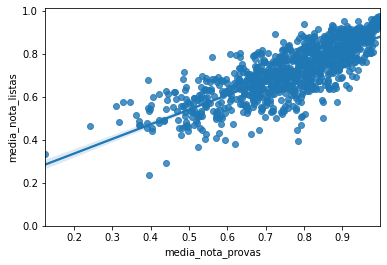

In [18]:
sns.regplot(x="media_nota_provas", y="media_nota_listas", data=df_norm)
plt.ylim(0,)

In [37]:
pearson_coef, p_value = stats.pearsonr(df_norm['media_nota_provas'], df_norm['media_nota_listas'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.7906502056098059  with a P-value of P = 1.1774548316656011e-211


(0.0, 1.041379191919192)

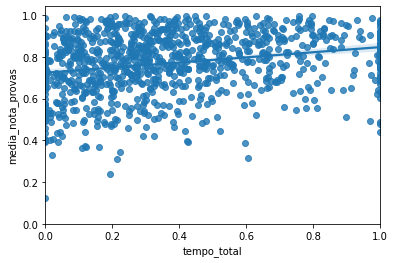

In [20]:
sns.regplot(y="media_nota_provas", x="tempo_total", data=df_norm)
plt.ylim(0,)

### Train/Test dataset

In [21]:
X = df_norm.drop(['usergroup_id','qmuser_id','media_nota_provas'], axis=1)

y = df_norm.media_nota_provas

In [22]:
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=9)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (788, 8) (788,)
Test set: (197, 8) (197,)


In [23]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_train, y_train), lr.score(x_test,y_test), (lr.score(x_train, y_train) + lr.score(x_test,y_test))

(0.7097272321636375, 0.7752981926636745, 1.485025424827312)

In [24]:
yhat_train = lr.predict(x_train)

yhat_test = lr.predict(x_test)

In [38]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(yhat_test - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((yhat_test - y_test) ** 2))
print("R2-score: %.2f" % r2_score(yhat_test , y_test) )

Mean absolute error: 0.06
Residual sum of squares (MSE): 0.01
R2-score: 0.63


In [26]:
lr.coef_

array([ 2.50328272e-02,  1.22973669e-01,  2.27219482e-02,  2.94904311e-02,
        7.08420910e-01, -3.44812325e-04,  1.39487165e-02,  8.40148252e-03])

In [46]:
lr.intercept_

0.11942193254360078

## Data Visualization

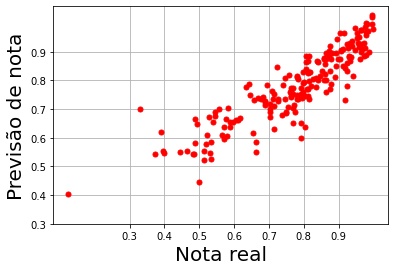

In [27]:
fig = plt.figure()
plt.plot(y_test , lr.predict(x_test), 'o', color='red', markersize = 5)
#plt.plot(y_test * desv_nota_test + media_nota_test, reg.predict(X_test) * desv_nota_test + media_nota_test, 'o', color='red', markersize = 5)
#plt.plot(linha, linha, '-', color = 'orange', linewidth = 5)
#plt.plot(linha, linha+margem, '-', color = 'orange', linewidth = 3)
#plt.plot(linha, linha-margem, '-', color = 'orange', linewidth = 3)
#plt.plot(linha, media_test+margem, '-', color = 'red', linewidth = 3)
#plt.plot(linha, media_test-margem, '-', color = 'red', linewidth = 3)
plt.xlabel('Nota real', fontsize = 20)
plt.ylabel('Previsão de nota', fontsize = 20)
plt.xticks(np.arange(0.3, 1, 0.1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.grid()
#plt.legend([get_key(train), get_key(test), 'faixa previsão','','faixa chute na média'], fontsize = 15)
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

## Clustering

In [28]:
df1=df_norm.set_index('qmuser_id', drop=True)
df1.drop('usergroup_id', axis=1, inplace=True)
df1.head()

,n_tarefas,media_nota_tarefas,n_listas,n_exercicios,media_nota_listas,n_pdfs,n_video,media_nota_provas,tempo_total
qmuser_id,,,,,,,,,
bra094196,0.250000,0.875,0.870968,0.736232,0.806685,0.573964,0.591549,0.903448,0.022408
bra101796,0.964286,1.000,0.838710,0.837681,0.656260,0.686391,0.774648,0.813559,0.048946
bra107727,1.000000,1.000,0.967742,1.000000,0.795008,0.914201,0.957746,0.872881,0.256612
bra101680,1.000000,1.000,0.978495,0.944928,0.775914,0.997041,0.943662,0.910169,0.465394
bra110248,0.107143,1.000,0.000000,0.176812,0.624644,0.000000,0.239437,0.733333,0.236738


In [29]:
df2 = df1.drop(['n_tarefas','n_listas','n_exercicios','n_pdfs','n_video','tempo_total'], axis=1)

In [39]:
#Run k-means to cluster the neighborhood into 5 clusters.

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init = "k-means++", random_state=5, n_init = 12).fit(df2)
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_

print('Training Complete!')

Training Complete!


In [40]:
np.unique(k_means_labels), k_means_cluster_centers

(array([0, 1, 2, 3]),
 array([[0.61251463, 0.64408754, 0.68220514],
        [0.11893219, 0.5658035 , 0.54760991],
        [0.89559766, 0.79805457, 0.88303612],
        [0.29337824, 0.77543131, 0.78211866]]))

In [41]:
#df2.drop('Cluster Labels', axis=1, inplace=True)
df2.insert(0, 'Cluster Labels', kmeans.labels_)

In [42]:
X = df2.values[:,:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)

In [43]:
df2.head()

,Cluster Labels,media_nota_tarefas,media_nota_listas,media_nota_provas
qmuser_id,,,,
bra094196,2,0.875,0.806685,0.903448
bra101796,2,1.000,0.656260,0.813559
bra107727,2,1.000,0.795008,0.872881
bra101680,2,1.000,0.775914,0.910169
bra110248,2,1.000,0.624644,0.733333


df_notime = df.drop(['media_tempo_tarefas','media_tempo_listas','media_tempo_pdfs','media_tempo_video'], axis=1)

df_notime.drop(df[df_notime.tempo_total > 5000].index, inplace=True)

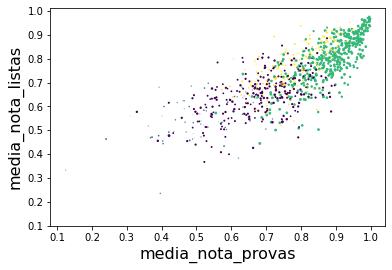

In [44]:
area = np.pi * ( X[:, 1])**2
plt.scatter(X[:, 3], X[:, 2], s=area, c=k_means_labels.astype(np.float), alpha=1)
plt.xlabel('media_nota_provas', fontsize=16)
plt.ylabel('media_nota_listas', fontsize=16)
plt.xticks(np.arange(0.1, 1.01, 0.1))
plt.yticks(np.arange(0.1, 1.01, 0.1))

plt.show()

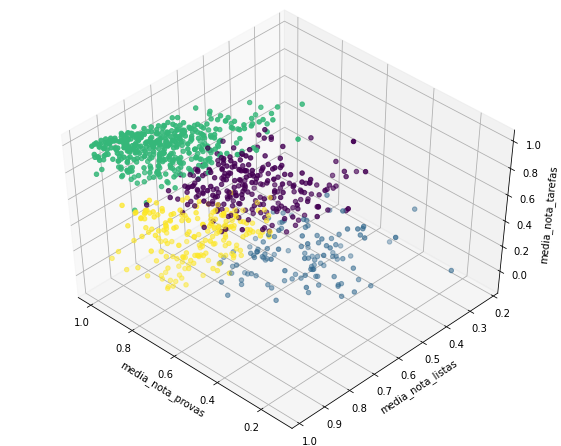

In [45]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('media_nota_provas')
ax.set_ylabel('media_nota_listas')
ax.set_zlabel('media_nota_tarefas')

ax.scatter(X[:, 3], X[:, 2], X[:, 1], c= k_means_labels.astype(np.float))